# Calculate the GW modes for each exoplanet that has the needed parameters in the dbase.

In [33]:
# Started WEG  20180320. 
# See the gwtools.py which has utility and strain functions in it
# and ExopDBase notebook that can download a new csv exop database.

# References
P. Amaro-Seoane et al. "Triplets of supermassive black holes: astrophysics, gravitational waves and detection," MNRAS 402 2308-2320 (2010).

P. C. Peters and J. Mathews, "Gravitational Radiation from Point Masses in a Keplerian Orbit," Phys. Rev. 131 (1963) 435-440.

Michele Maggiore, "Gravitational Waves. Volume 1: Theory and Experiments," Oxford Univ. Press, 2008.

Shane Larson, "Sensitivity Curves for ..."  http://www.srl.caltech.edu/~shane/sensitivity/

Neil Cornish and Travis Robson, "The construction and use of LISA sensitivy curves," https://arxiv.org/abs/1803.01944

In [34]:
import sys, os
import numpy as np
import pandas as pd
import gwTools as gwt
import matplotlib.pyplot as plt
%matplotlib inline
import scipy as sp
import scipy.interpolate as spint

## Directories for the dbase and to save plots.

In [35]:
thisDir = os.getcwd()  # This is the /python subdirectory.
cvsDir = thisDir + '/../dbases/'  # Will the /../ work on non-Unices?
pixDir = thisDir + '/../pix/'

## Read the CSV file and drop the rows/exops with NaN in the important fields.  See ExopDBase.ipynb and re-run it for updating the dbase.

In [36]:
cvsFileName = cvsDir + 'exopP_20180403_110820.csv'
print('Using database file ' + cvsFileName)
with open(cvsFileName, 'r') as ifile:
    print(ifile.readline(), '\n', ifile.readline() )  #Print a couple of lines and reset the pointer.

    ifile.seek(0);

    dbData = pd.read_csv(ifile)  # Read in the whole file to a Panda Dataframe, handles NaN's nicely, see below.
    #ifile.close()  # Should close when you leave the "with."

Using database file /home/gabella/Documents/astro/exop/exoplanetsMath/python/../dbases/exopP_20180403_110820.csv
pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx
 
 HD 142022 A,b,Radial Velocity,1928.00000000,3.030000,0.530000,5.10000,35.87,0.99,2014-05-14,27.88



In [37]:
dbData.head(10)  # NaN's show up when the field has no data.  Need both masses, eccentricity, semimajor axis, 
# and distance.

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx
0,HD 142022 A,b,Radial Velocity,1928.000000,3.0300,0.5300,5.100,35.87,0.99,2014-05-14,27.88
1,HD 39091,b,Radial Velocity,2151.000000,3.3800,0.6405,10.270,18.21,1.10,2014-07-23,54.92
2,HD 137388 A,b,Radial Velocity,330.000000,0.8900,0.3600,0.223,38.45,0.86,2014-05-14,26.01
3,GJ 3021,b,Radial Velocity,133.710000,0.4900,0.5110,3.370,17.62,0.90,2014-05-14,56.76
4,HD 63454,b,Radial Velocity,2.818049,0.0368,0.0000,0.398,35.80,0.84,2015-03-26,27.93
5,HD 212301,b,Radial Velocity,2.245715,0.0360,0.0000,0.450,52.72,1.27,2014-05-14,18.97
6,CHXR 73,b,Imaging,NaN,210.0000,NaN,12.569,NaN,0.35,2014-05-14,NaN
7,CT Cha,b,Imaging,NaN,440.0000,NaN,17.000,165.00,NaN,2014-05-14,NaN
8,HD 196067,b,Radial Velocity,3638.000000,5.0200,0.6600,6.900,43.57,1.29,2014-05-14,22.95
9,HD 68402,b,Radial Velocity,1103.000000,2.1800,0.0300,3.070,78.00,1.12,2016-11-10,12.82


## Drop the exops/rows with NaN in the following fields: pl_orbeccen (eccentricity), pl_orbper (orbital period), pl_obsmax (semimajor axis), pl_bmassj (planet mass), st_dist (distance to host star), st_mass (stellar mass)

In [38]:
# {"pl_hostname", "pl_letter", "pl_discmethod", "pl_orbper", \
# "pl_orbsmax", "pl_orbeccen", "pl_bmassj", "st_dist", "st_mass", \
# "rowupdate", "st_plx"}
print('Length all data, dbData ', len(dbData) )
aData = dbData.dropna(axis = 0, how = 'any', subset = ['pl_orbeccen'])
print('Length with pl_orbeccen\t', len(aData) )
aData = aData.dropna(axis = 0, how = 'any', subset = ['pl_orbper'])
print('Length with pl_orbper\t', len(aData) )
aData = aData.dropna(axis = 0, how = 'any', subset = ['pl_orbsmax'])
print('Length with pl_orbsmax\t', len(aData) )
aData = aData.dropna(axis = 0, how = 'any', subset = ['pl_bmassj'])
print('Length with pl_bmassj\t', len(aData) )
aData = aData.dropna(axis = 0, how = 'any', subset = ['st_dist'])
print('Length with st_dist\t', len(aData) )
aData = aData.dropna(axis = 0, how = 'any', subset = ['st_mass'])
print('Length with st_mass\t', len(aData) )

Length all data, dbData  3708
Length with pl_orbeccen	 1172
Length with pl_orbper	 1172
Length with pl_orbsmax	 1107
Length with pl_bmassj	 1027
Length with st_dist	 920
Length with st_mass	 910


In [39]:
#  So adata is the working exoplanet data frame after filtering as a Panda DataFrame.  Later should consider 
#  filling in missing data with Kepler or other calculations.

##  Physical Constants, made explicit here.  The CalTech exop dbase has an FAQ on the units they use for each parameter.

In [40]:
# Some scipy.constants for comparison mostly.
from scipy.constants import speed_of_light, gravitational_constant, c, G, pi

massSun = 1.989e30; #(*kg *)
massJ = 1.898e27; #(* kg *)
massE = 5.972e24; #(* kg *)
massJe = massJ/massE; #(* Jupiter mass is 317.9 earth masses *)
massJs = massJ/massSun; #(* relative to the sun's mass *)

pc = 30.86e15; #(* meters, parsec *)
au = 149.6e9; #(* meters, astron unit *)

cee = 299792458.0; #(* meters/s, speed of light *)
print('Compare my cee ', cee, ' and scipy.constants ', speed_of_light)
cee = speed_of_light # Use the scipy.constants one.
secsYear = 365.24*24.0*3600.0; #(* s, number of seconds in a year *) # What do astronomers use for this conversion?
secsDay = 24.0*3600.0; #(* s, number of seconds in a day *)

bigG = 6.67408e-11; #(* SI Gravitational constant, m^3/kg/s *)
print('Compare my bigG ', bigG, ' and scipy.constants ', gravitational_constant)
bigG = gravitational_constant

rscon = 2*bigG*massSun/(cee*cee) #(* 2955.43 m, solar mass Scharzschild radius *)
lunits = bigG*massSun/(cee*cee) #(* meters per solar mass, units of G=c=1, no factor
#of 2 as in Schwarzschild radius *)
masscon = lunits; #(* m, G Msol/c^2, for 1 solar mass *)
powercon = cee**5/bigG  #(* 3.628e52 W, c^5/G, W/unit since P is dimensionless in G=c=1 units *)
energycon = (cee**4)/bigG  #(* 1.210e44 J/m, c^4/G *)

Compare my cee  299792458.0  and scipy.constants  299792458.0
Compare my bigG  6.67408e-11  and scipy.constants  6.67408e-11


## Calculate some GW amplitudes for each exoplanet.

### Make a plot of the maximum strain mode number versus eccentricity.  This "n-star" is used to truncate the number of GW modes used.  The n-star is chosen such that  g(n-star, e) = 0.05 , note that  g(2,e=0) = 1 and the maximum goes up from there.  Also for small eccentricities but e$\ne$0, always use modes [1,2,3], though n=2 is the strongest usually.  For e=0, use just [2].

n-star(ecc) comes from a fit done in mathematica, see gwtools.py, aNmax(ecc) function.


Text(0.5,1,'The n-star, where the g(n,e) curve\n comes back to the value 0.05.')

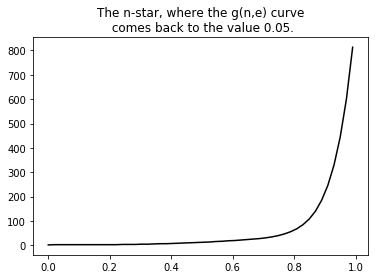

In [41]:
print('n-star(ecc) comes from a fit done in mathematica, see gwtools.py, aNmax(ecc) function.')
ecc = np.linspace(0., 0.99, 50)
nstar = [ gwt.aNmax(uu) for uu in ecc ]
plt.plot(ecc, nstar, 'k-')
plt.title('The n-star, where the g(n,e) curve\n comes back to the value 0.05.')

### Check the above function for some eccentricity.

For example, look at the g(n,e) curve for ecc =  0.9
The n-star is  216.0
max is  17.395364810603994


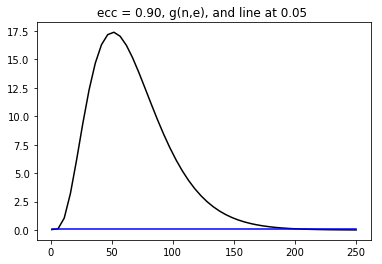

max is  0.10849779715995705


Text(215,0.06,'n-star')

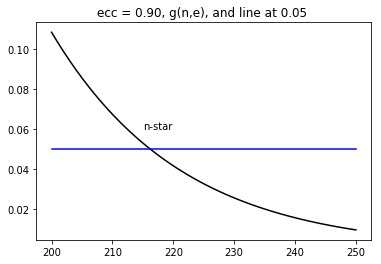

In [42]:
ecc = 0.9 # Eccentricity
print('For example, look at the g(n,e) curve for ecc = ', ecc)
print('The n-star is ', gwt.aNmax(ecc) )
#
# full g(n,e) curve
#
mmin = 1
mmax = 250
modes = np.linspace(mmin,mmax,50)
gne = gwt.ggSimp(modes, ecc)
plt.plot(modes, gne, 'k-')
# The line at 1/20th max is...
yval = 0.05
print('max is ', np.max( gne ) )
plt.plot( [mmin, mmax], [yval, yval], 'b-')
plt.title('ecc = %.2f, g(n,e), and line at 0.05 '%(ecc) )
plt.show()
#
# close up
#
mmin = 200
mmax = 250
modes = np.linspace(mmin,mmax,50)
gne = gwt.ggSimp(modes, ecc)
plt.plot(modes, gne, 'k-')
# The line at 1/20th max is...
yval = 0.05
print('max is ', np.max( gne )  )
plt.plot( [mmin, mmax], [yval, yval], 'b-')
plt.title('ecc = %.2f, g(n,e), and line at 0.05 '%(ecc) )
plt.text(215,0.06,'n-star')

## Create a numpy array of GW strain amplitudes for that planet and append to the table.

Using the formula from Amaro-Seoane et al. reference, Eqn. (9)
$$ h_{n} = 2 \sqrt{\frac{32}{5}} \frac{ {\frak M}^{5/3} }{n\,d_{L}} \big( 2\pi f_{r} \big) \sqrt{g(n,e)}$$
where $e$ is the eccentricity, $n$ is the mode number, ${\frak M}$ is the chirp mass $M_{1}^{3/5}M_{2}^{3/5}/(M_{1}+M_{2})^{1/5}$, $d = d_{L}/(1+z)$, and $f_{r}$ is the orbital frequency, so the mode frequency is $f = f_{r}\,n$ for $n=(1,2,3...)$.  I like the chirp mass as $\mu^{3/5} M^{2/5}$ with reduced mass $\mu$ and total mass $M$ for the binary.

The above is found in gwtools.py as  hh(nn, ee, m1, m2, a, dL).

Does not render the above perfectly.  Looks like a font problem on the square root.  Otherwise okay.

In [43]:
help(gwt.hh)
help(gwt.orbitalFreq)

Help on function hh in module gwTools:

hh(nn, ee, m1, m2, a, dL)
    From Amaro-Seoane et al. 2010, the GW amplitude for GW mode nn in units of
    the orbital frequency, eccentricity ee, binary masses m1 and m2, 
    semi-major axis a, and distance to source dL.  Use SI units.
    Returns the GW amplitude for that frequency mode.
    Amaro-Seoane et al. Eqn. (9), refs Finn and Thorne 2000.

Help on function orbitalFreq in module gwTools:

orbitalFreq(m1, m2, a)
    Given two masses, m1 and m2, and the semimajor axis a,
    return the orbital frequency in Hz from Kepler relations.



In [44]:
aData.head(4)  # To see the headers:)

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx
0,HD 142022 A,b,Radial Velocity,1928.00,3.03,0.5300,5.100,35.87,0.99,2014-05-14,27.88
1,HD 39091,b,Radial Velocity,2151.00,3.38,0.6405,10.270,18.21,1.10,2014-07-23,54.92
2,HD 137388 A,b,Radial Velocity,330.00,0.89,0.3600,0.223,38.45,0.86,2014-05-14,26.01
3,GJ 3021,b,Radial Velocity,133.71,0.49,0.5110,3.370,17.62,0.90,2014-05-14,56.76


### Explicitly use Amaro-Seoane et al. Eqn (9), so that we can see it.  Do NOT use gwt.hh().  Note the physical constants are back, $G^{5/3}/c^{4}$ to make it dimensionless when we use SI units for all the other parameters.

In [45]:
# Actually append n_min, n_max, numpy array of GW strains h.
# In the Mathematica JustStrainPlots.nb, about 40% down, calc hhVfreq first time.

hhmodesCol = []  # Setup a list of the hhmodes that will be appended to the dataframe.
modesCol = []    # The modes set acually used for the calculation, int(modeMin) to int(modeMax)+1
freq0Col = []    # Collect the orbital frequency that was used.

for irow in range(len(aData)):
    # Calculate the SI parameters needed by the strains and the strain "front coefficient."
    
    orbeccen = aData['pl_orbeccen'].values[irow]
    modeMax = gwt.aNmax( orbeccen )  # The "max" mode number where g(n,e) returns to 1/20th its peak value.
    modeMin = gwt.aNmin( orbeccen )  # Either 1 for e>0 or 2 for e=0.
    #
    m1 = aData['pl_bmassj'].values[irow]*massJ
    m2 = aData['st_mass'].values[irow]*massSun
    smax = aData['pl_orbsmax'].values[irow]*au
    dL = aData['st_dist'].values[irow]*pc
    freq0 = 1.0/( aData['pl_orbper'].values[irow]*secsDay )
    # Amaro-Seoane Eqn. (9)...common terms.
    frontCoeff = np.power(bigG,5/3.)/cee**4 * 2 * np.sqrt(32/5.) * np.power( gwt.chirpM(m1,m2), 5/3.)*\
    np.power((2*np.pi*freq0), 2/3.)/dL
    if irow > 6 and irow < 15:
        print('irow is ', irow, ' ,frontCoeff is ', frontCoeff, ' pl_orbeccen is ', orbeccen)

    # Now loop over the GW modes and calc the dim-less strain and the modes used.
    hhmodes = [ frontCoeff* np.sqrt( gwt.ggSimp(uu, orbeccen) )/uu for uu in range(int(modeMin), int(modeMax)+1)  ]
    modes = [ uu for uu in range(int(modeMin), int(modeMax)+1)  ]
    
    # Append to the list.
    hhmodesCol.append( hhmodes )
    modesCol.append( modes )
    freq0Col.append( freq0 )
        

irow is  7  ,frontCoeff is  4.6311021600204593e-26  pl_orbeccen is  0.03
irow is  8  ,frontCoeff is  2.169114619938696e-26  pl_orbeccen is  0.41
irow is  9  ,frontCoeff is  2.5108674723286658e-25  pl_orbeccen is  0.638
irow is  10  ,frontCoeff is  6.772473061612905e-26  pl_orbeccen is  0.85
irow is  11  ,frontCoeff is  2.4969184134452682e-26  pl_orbeccen is  0.08
irow is  12  ,frontCoeff is  4.643709659681133e-25  pl_orbeccen is  0.0
irow is  13  ,frontCoeff is  7.140502406734836e-26  pl_orbeccen is  0.29
irow is  14  ,frontCoeff is  1.2172309568518269e-25  pl_orbeccen is  0.54


In [46]:
# Check there is stuff in there.
print( len(hhmodesCol[0] ) )
print( hhmodesCol[0] )
print( modesCol[0] )

15
[1.8702816437643177e-26, 2.1740658908129503e-26, 2.882158933335889e-26, 2.664860375595358e-26, 2.1935963182104775e-26, 1.7069345750672433e-26, 1.2854210432619556e-26, 9.475882743564367e-27, 6.882115822891534e-27, 4.9437540797700044e-27, 3.5216043707537875e-27, 2.4919659046939435e-27, 1.7539322636285046e-27, 1.2290258111169294e-27, 8.58019444780923e-28]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]


In [47]:
#Append the hhmodesCol to the dataframe, for ease of getting at the other attributes.
aData['freq0'] = freq0Col
aData['modes'] = modesCol
aData['hhmodes'] = hhmodesCol

In [48]:
# Check that appending happened correctly.
aData.head(3)

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx,freq0,modes,hhmodes
0,HD 142022 A,b,Radial Velocity,1928.0,3.03,0.5300,5.100,35.87,0.99,2014-05-14,27.88,6.003150e-09,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.8702816437643177e-26, 2.1740658908129503e-2..."
1,HD 39091,b,Radial Velocity,2151.0,3.38,0.6405,10.270,18.21,1.10,2014-07-23,54.92,5.380788e-09,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[8.230508420052954e-26, 4.507375225359441e-26,..."
2,HD 137388 A,b,Radial Velocity,330.0,0.89,0.3600,0.223,38.45,0.86,2014-05-14,26.01,3.507295e-08,"[1, 2, 3, 4, 5, 6, 7]","[1.6721119496253516e-27, 4.481574164761941e-27..."


## Plot all the dimless strain modes for each planet that survives all the NaN checks.

In [49]:
# Loop over exops.  This CAN be simplified.
# xfreqs = []
# yhhs = []
# for irow in range(len(aData)):
#     nmodes = len(aData['modes'][irow])
#     freq0 = aData['freq0'][irow]
#     for imodes in range(nmodes):
#         xfreqs.append(  aData['modes'].values[imodes] )
#         yhhs.append( aData['hhmodes'].values[imodes] )
        
# plt.plot(xfreqs, yhhs, 'ko')
        

## Use the calculated data and the Larson S_n(f) curve averaged/integrated over 1 year.  For the future use the Cornish-Robson noise curve as standard, definitely compare.

The Larson curve from http://www.srl.caltech.edu/~shane/sensitivity/MakeCurve.html , for dimensionless strain says 1 year integration time (?)

In [50]:
# Load one or other of the Larson curves
larsonASDFile = 'scg_5597_2W_2p5e9m.dat'  # Amplitude Spectral Densities, ASD's in per root Hz!!!
larsonASD = pd.read_csv( thisDir + '/' + larsonASDFile, header=None, delim_whitespace=True, \
                               names=['freq[Hz]', 'ASD[Hz^-1/2]'], skiprows=22 )
larsonASD.head(3)

,freq[Hz],ASD[Hz^-1/2]
0,1.953007e-07,4.115269e-12
1,1.998512e-07,3.929997e-12
2,2.045077e-07,3.753070e-12


In [51]:
# Append the 1 year integrated dimension-less by dividing ASD by sqrt(1 year in secs).  Check this!!
larsonASD['h[dimless,1yr]'] = larsonASD['ASD[Hz^-1/2]'].values/np.sqrt(1.0*secsYear)

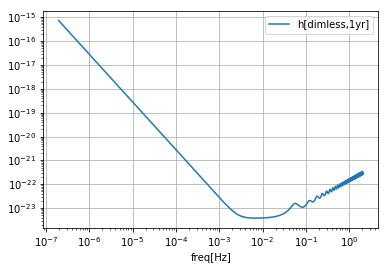

In [52]:
larsonASD.plot(x = 'freq[Hz]', y = 'h[dimless,1yr]', logy=True, logx=True, grid=True)

## The 1 year Larson curve and the individual modes for each exoplanet.

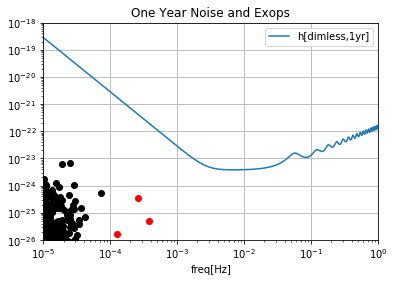

In [53]:
# plotting different dataframes in same plot
#ax = df1.plot()
#df2.plot(ax=ax)

ax = larsonASD.plot(x = 'freq[Hz]', y = 'h[dimless,1yr]', logy=True, logx=True, grid=True)
for irow in range(len(aData)):
    aa = aData['freq0'].values[irow]
    xx = [aa * uu for uu in aData['modes'].values[irow]  ] 
    yy = aData['hhmodes'].values[irow]
    acolor = 'ko'
    if aData['pl_hostname'].values[irow] == 'PSR J1719-1438':  # Flag the brightest one with red dots.
        if aData['pl_letter'].values[irow] == 'b':
            acolor = 'ro'
    ax.plot( xx, yy, acolor)
    ax.set_ylim((1e-26, 1e-18) )
    ax.set_xlim((1e-5, 1.0) )
    ax.set_title('One Year Noise and Exops')
    

In [54]:
# Print the row for exop ...
for irow in range(len(aData) ):
    if aData['pl_hostname'].values[irow] == 'PSR J1719-1438' and \
    aData['pl_letter'].values[irow] == 'b':
        theRow = irow
        print( aData.values[irow] )

['PSR J1719-1438' 'b' 'Pulsar Timing' 0.09070629 0.0044 0.06 1.2 1200.0
 1.4 '2014-05-14' nan 0.0001275994649772808 list([1, 2, 3])
 list([1.681497004686017e-26, 3.5797366388109786e-25, 4.8348526229385945e-26])]


In [55]:
gwt.aNmax(0.06)  # If e>0 always have at least three modes, n = 1,2,3 .

3.0

Text(0.5,1,'n-star on semilog plt versus eccentricity')

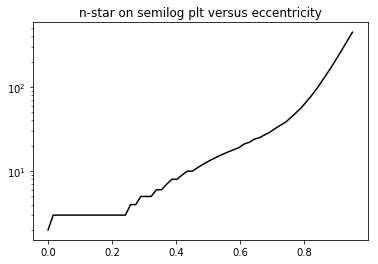

In [56]:
xx = np.linspace(0,0.95, 60)
yy= [ gwt.aNmax(uu) for uu in xx ]
plt.semilogy(xx, yy, 'k-')
plt.title('n-star on semilog plt versus eccentricity')

## Calculate the signal-to-noise ratio for each planet.

Testing the linear interp in log-log space of the dep and indep variables.


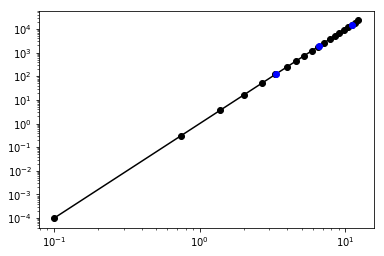

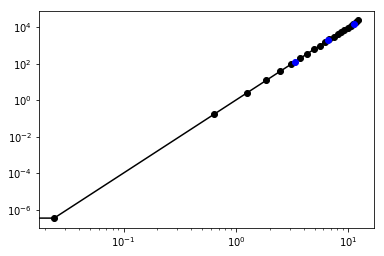

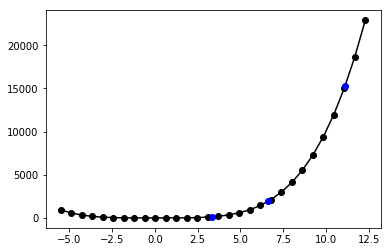

In [57]:
# Will need to interpolate the S_n(f) functions.
# Do the linear interpolation in the log-space since it is so linear there.
class snLinInterp:

    """Input the numpy arrays of freqs and sns and returns a class with
    a __call__ function.  Not good checks for values <=0 or if you are interpolating
    outside the range it was setup in, so use carefully.
    """
    def __init__(self, freqs, sns):
        from scipy.interpolate import interp1d
        # Check lenght of arrays agree.
        if len(freqs) != len(sns):
            print('***class snLinInterp: error, arrays lengths disagree, len(freqs) ', len(freqs), ' and '\
                 'len(sns) is ', len(sns) )
        else:
        # Check for zero in each array.  Cannot use x[x>0] as usual, need arrays coordinated.
            idrop = []
            for ii in range(len(freqs)):
                if freqs[ii] <= 0 or sns[ii] <= 0:
                    idrop.append(ii)

            self.freqs = np.delete(freqs,idrop)
            self.sns = np.delete(sns, idrop)
            self.logFreqs = np.log10(self.freqs)
            self.logSns = np.log10(self.sns)
            self.myInterp1D = interp1d(freqs, sns)  # Leave it linear for now. scipy.interpolate.
            self.minFreq = np.min(self.freqs)
            self.maxFreq = np.max(self.freqs)  # Can only interp between the values min freq and max.
        
    def __call__(self, uu):  # Checking for negatives and zeros is a pain, just do not do it for now!!
        return( self.myInterp1D(uu) )
        
xx = np.linspace(0.1, 12.3, 20)
yy = np.power(xx,4)
snInterp = snLinInterp(xx, yy )  # Has the __call__ method, so makes a 1D function.
xint = [3.33, 6.6, 11.11]
yint = snInterp(xint)
ax = plt.loglog(xx,yy,'ko-', xint, yint, 'bo')
# set_title('Testing the linear interp in log-log space of the dep and indep variables.')
print( 'Testing the linear interp in log-log space of the dep and indep variables.' )
plt.show()

# Test handling of the negatives and zero values!
xx = np.linspace(-5.5, 12.3, 30)
yy = np.power(xx,4)
snInterp2 = snLinInterp(xx, yy) # trying negatives for x but all positives for y, should drop both values.

xint = np.array([3.33, 6.6, 11.11])
yint = snInterp(xint)
plt.loglog(xx,yy,'ko-', xint, yint, 'bo')
plt.show()
plt.plot(xx,yy,'ko-', xint, yint, 'bo')
plt.show()

In [58]:
# Load one or other of the Larsen curves
larsonASDName = 'scg_5597_2W_2p5e9m.dat';  # This has right arm lengths, other nos. seem reasonable.
larsonASD = pd.read_csv( thisDir + '/' + larsonASDName, header=None, delim_whitespace=True, \
                               names=['freq[Hz]', 'ASD[Hz^-1/2]'], skiprows=22 )
larsonASD.head(3)

,freq[Hz],ASD[Hz^-1/2]
0,1.953007e-07,4.115269e-12
1,1.998512e-07,3.929997e-12
2,2.045077e-07,3.753070e-12


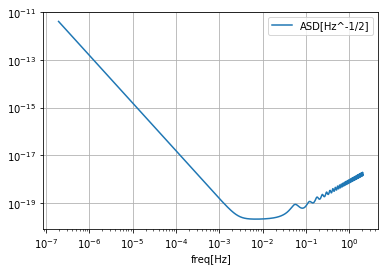

In [59]:
ax = larsonASD.plot(x = 'freq[Hz]', y = 'ASD[Hz^-1/2]', logy=True, logx=True, grid=True)


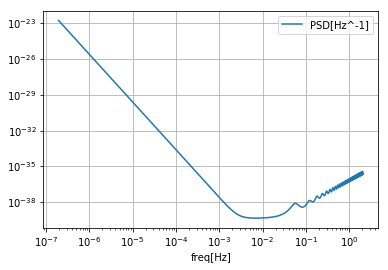

In [60]:
# Append the PSD, per root Hz.  What we need for the SNR**2 formualae.
larsonASD['PSD[Hz^-1]'] = larsonASD['ASD[Hz^-1/2]']**2
bx = larsonASD.plot(x = 'freq[Hz]', y = 'PSD[Hz^-1]', logy=True, logx=True, grid=True)

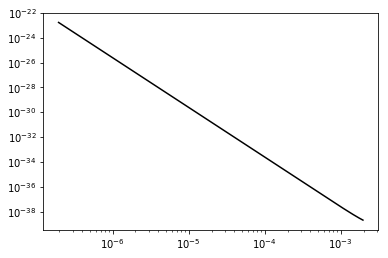

In [61]:
# Setup the interpolating for the S_n(f) int he range below f = 2e-3 Hz.
xfreqsA = larsonASD['freq[Hz]'].values
yPSDA = larsonASD['PSD[Hz^-1]'].values # Define the full data as numpy arrays.
#(xfreqs, yPSD) = [ (uu, vv ) if uu <= 2e-3 for (uu, vv) in (xfreqsA, yPSDA)  ]
xfreqs = xfreqsA[xfreqsA<=2e-3]
yPSD = yPSDA[xfreqsA<=2e-3]

plt.loglog( xfreqs, yPSD, 'k-')

In [62]:
mySnInterp = snLinInterp( xfreqs, yPSD )
# To handle the really low frequency modes use the linear fit in the log-log space:
# Larson formula for now.  From Mathematica GWExopSNR.nb
#ssubn[freq_] := 0.1642*10^-48/freq^4
#
# Actually the fit in the python notebook for the left hand side of the S_n(f) from Larson's Sqrt[S_n(f)] 
# was TeXForm[f^-3.9946\cdot 1.6421 \cdot 10^-49]  .
def ssubn(freq):
    return( (0.1642e-48/freq**4) )

# It is the sum over the modes.
intTime = 1.0*secsYear  # Integration time in seconds.

SNRCols = []
for irow in range(len(aData) ):
    freq0 = aData['freq0'].values[irow]
    modes= aData['modes'].values[irow]
    hhmodes = aData['hhmodes'].values[irow]
    SNRSqSum = 0.0
    for jmodes in range(len(modes) ):   # Calc the SQUARE of the SNR!
        amode = modes[jmodes]
        SNRSqSum += 2.0*intTime*hhmodes[jmodes]**2/ssubn(amode*freq0)
#        SNRSqSum += 2.0*intTime*hhmodes[jmodes]**2/mySnInterp(amode*freq0)
    SNRCols.append( np.sqrt(SNRSqSum) )
        
print('len(SNRCols) is ', len(SNRCols) )
aData['SNR']=SNRCols
print('len(aData) is ', len(aData) )
    

len(SNRCols) is  910
len(aData) is  910


In [63]:
len(aData)

910

In [64]:
aData.head(3)

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx,freq0,modes,hhmodes,SNR
0,HD 142022 A,b,Radial Velocity,1928.0,3.03,0.5300,5.100,35.87,0.99,2014-05-14,27.88,6.003150e-09,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.8702816437643177e-26, 2.1740658908129503e-2...",1.171337e-12
1,HD 39091,b,Radial Velocity,2151.0,3.38,0.6405,10.270,18.21,1.10,2014-07-23,54.92,5.380788e-09,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[8.230508420052954e-26, 4.507375225359441e-26,...",9.018521e-12
2,HD 137388 A,b,Radial Velocity,330.0,0.89,0.3600,0.223,38.45,0.86,2014-05-14,26.01,3.507295e-08,"[1, 2, 3, 4, 5, 6, 7]","[1.6721119496253516e-27, 4.481574164761941e-27...",1.716782e-12


In [65]:
bData = aData.sort_values(by = 'SNR', ascending = False)
bData.head(3)

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx,freq0,modes,hhmodes,SNR
491,PSR J1719-1438,b,Pulsar Timing,0.090706,0.00440,0.0600,1.2000,1200.00,1.40,2014-05-14,NaN,0.000128,"[1, 2, 3]","[1.681497004686017e-26, 3.5797366388109786e-25...",0.000478
156,WASP-18,b,Transit,0.941453,0.02026,0.0092,10.4300,105.49,1.28,2014-05-14,9.48,0.000012,"[1, 2, 3]","[5.044293986239611e-26, 7.052792899222313e-24,...",0.000084
336,PSR J2322-2650,b,Pulsar Timing,0.322964,0.01020,0.0017,0.7949,230.00,1.40,2017-12-21,4.40,0.000036,"[1, 2, 3]","[7.075677179501135e-28, 5.354424563392014e-25,...",0.000054


In [66]:
# Print the table that Mathematica does and what is in the paper.
astr = 'name                \teccen\tper(days)\tSNR\tindex\n'
print(astr)
for ii in range(16):
    astr = '%-20s\t%6.4f\t%.3f\t%.3g\t%d'%\
    (bData['pl_hostname'].values[ii]+' '+bData['pl_letter'].values[ii], bData['pl_orbeccen'].values[ii], 
     bData['pl_orbper'].values[ii], 
     bData['SNR'].values[ii], ii)
    print(astr)


name                	eccen	per(days)	SNR	index

PSR J1719-1438 b    	0.0600	0.091	0.000478	0
WASP-18 b           	0.0092	0.941	8.37e-05	1
PSR J2322-2650 b    	0.0017	0.323	5.39e-05	2
KELT-1 b            	0.0099	1.218	4.51e-05	3
WASP-43 b           	0.0000	0.813	1.64e-05	4
tau Boo b           	0.0110	3.312	8.45e-06	5
KELT-9 b            	0.0000	1.481	6.07e-06	6
KELT-16 b           	0.0000	0.969	5.26e-06	7
WASP-77 A b         	0.0000	1.360	5.1e-06	8
WASP-19 b           	0.0020	0.789	4.59e-06	9
WASP-14 b           	0.0910	2.244	3.98e-06	10
HATS-18 b           	0.1660	0.838	3.77e-06	11
HAT-P-2 b           	0.5171	5.633	3.57e-06	12
XO-3 b              	0.2600	3.192	3.54e-06	13
HAT-P-20 b          	0.0150	2.875	3.16e-06	14
HD 73256 b          	0.0290	2.549	2.69e-06	15


In [67]:
1/(111.3*24*3600.)

1.039898838640977e-07

In [68]:
cData = aData.sort_values(by = 'pl_orbeccen', ascending = False)
cData.head(6)

,pl_hostname,pl_letter,pl_discmethod,pl_orbper,pl_orbsmax,pl_orbeccen,pl_bmassj,st_dist,st_mass,rowupdate,st_plx,freq0,modes,hhmodes,SNR
304,HD 20782,b,Radial Velocity,597.0650,1.397,0.9560,1.43,35.50,1.02,2016-05-19,NaN,1.938495e-08,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.2814629622279826e-26, 9.037349908557032e-27...",1.752908e-08
3570,HD 80606,b,Radial Velocity,111.4357,0.449,0.9332,3.94,29.04,0.97,2014-05-14,17.13,1.038633e-07,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.30740990715796e-25, 8.506293791204289e-26, ...",1.366542e-06
199,HD 4113,b,Radial Velocity,526.6200,1.280,0.9030,1.56,44.05,0.99,2014-12-03,22.70,2.197804e-08,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.2594583314652946e-26, 7.233458381856687e-27...",1.713695e-09
23,HD 76920,b,Radial Velocity,415.4000,1.149,0.8560,3.93,184.80,1.17,2017-11-30,NaN,2.786248e-08,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.0138731199811866e-26, 4.557659817080447e-27...",5.919106e-10
12,HD 108341,b,Radial Velocity,1129.0000,2.000,0.8500,3.50,49.40,0.84,2015-01-08,20.23,1.025162e-08,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.3931095245605775e-26, 6.037948261699841e-27...",9.602185e-11
393,HD 98649,b,Radial Velocity,4951.0000,5.600,0.8500,6.80,42.77,1.00,2014-05-14,23.38,2.337725e-09,"[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...","[1.3095832207217623e-26, 5.675932575080468e-27...",4.693750e-12
